# Goal: convolutionl network with width normalization in preprocessing on MNIST database

convolutional networks perform feature extraction

general steps of convolutional networks:
1. filter with a convolution layer
2. detect with ReLU activation
3. condense with a maximum pooling layer

The sliding window:

a. The convolution and pooling operations share a common feature: they are both performed over a sliding window. With convolution, this "window" is given by the dimensions of the kernel, the parameter kernel_size. With pooling, it is the pooling window, given by pool_size.

b. There are two additional parameters affecting both convolution and pooling layers -- these are the strides of the window and whether to use padding at the image edges. The strides parameter says how far the window should move at each step, and the padding parameter describes how we handle the pixels at the edges of the input.

c. Because we want high-quality features to use for classification, convolutional layers will most often have strides=(1, 1). Increasing the stride means that we miss out on potentially valuble information in our summary. Maximum pooling layers, however, will almost always have stride values greater than 1, like (2, 2) or (3, 3), but not larger than the window itself.

## Procedure

Step 1: Load the data

Step 2: Define Model

Step 3: Train


-> Boost performance by creating extra training data

In [ ]:
#path = "/kaggle/input/digit-recognizer/train.csv"
#mnist = pd.read_csv(path)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
s1 = x_train.shape
s2 = x_test.shape
print(f"The MNIST data was loaded with {s1[0]} training samples and {s2[0]} testing samples.")
print(f"Each sample is a {s1[1]} x {s1[2]} pixel image.")

The MNIST data was loaded with 60000 training samples and 10000 testing samples.
Each sample is a 28 x 28 pixel image.


Epoch 1/20
1500/1500 [==============================] - 41s 27ms/step - loss: 0.1750 - accuracy: 0.9462 - val_loss: 0.0911 - val_accuracy: 0.9728
Epoch 2/20
1500/1500 [==============================] - 40s 27ms/step - loss: 0.0589 - accuracy: 0.9821 - val_loss: 0.0682 - val_accuracy: 0.9808
Epoch 3/20
1500/1500 [==============================] - 38s 25ms/step - loss: 0.0378 - accuracy: 0.9884 - val_loss: 0.0564 - val_accuracy: 0.9832
Epoch 4/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.0246 - accuracy: 0.9919 - val_loss: 0.0562 - val_accuracy: 0.9835
Epoch 5/20
1500/1500 [==============================] - 38s 26ms/step - loss: 0.0180 - accuracy: 0.9939 - val_loss: 0.0558 - val_accuracy: 0.9846
Epoch 6/20
1500/1500 [==============================] - 39s 26ms/step - loss: 0.0112 - accuracy: 0.9966 - val_loss: 0.0525 - val_accuracy: 0.9859
Epoch 7/20
1500/1500 [==============================] - 38s 26ms/step - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.0653 -

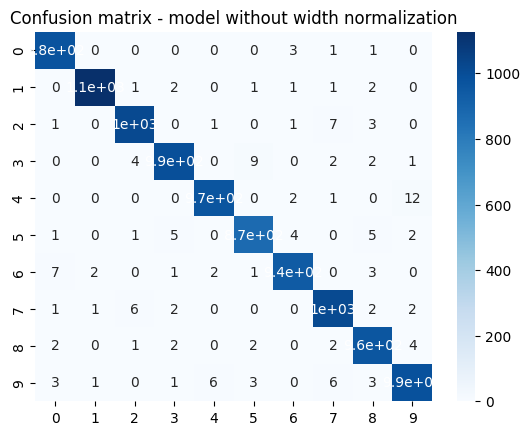

Model with width normalization
Test accuracy: 0.9861000180244446
313/313 [==============================] - 3s 8ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.97      0.98      1028
           8       0.98      0.99      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

313/313 [==============================] - 3s 8ms/step


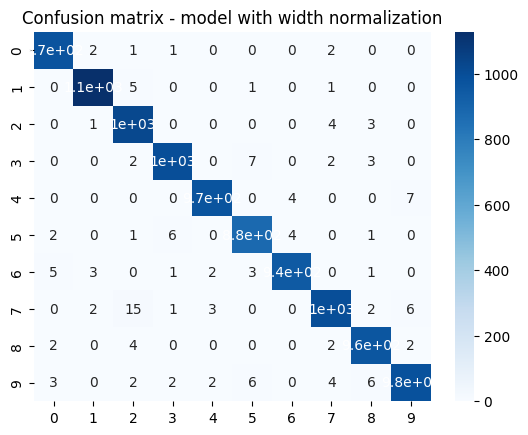

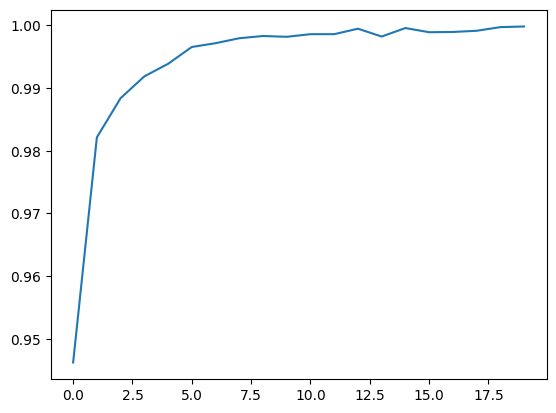

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define width normalization function using Lambda layer
def width_normalization(x):
    mean = tf.math.reduce_mean(x, axis=-1, keepdims=True)
    std = tf.math.reduce_std(x, axis=-1, keepdims=True)
    return (x - mean) / std

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values to range [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add channel dimension to images
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Define models
def get_model(use_width_norm=False):
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)

    if use_width_norm:
        x = layers.Dense(128, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Lambda(width_normalization)(x)
        outputs = layers.Dense(10, activation="softmax")(x)
    else:
        x = layers.Dense(128, activation="relu")(x)
        outputs = layers.Dense(10, activation="softmax")(x)

    return keras.Model(inputs, outputs)

# Create models and compile them
model_no_norm = get_model(use_width_norm=False)
model_norm = get_model(use_width_norm=True)

opt = keras.optimizers.legacy.Adam(learning_rate=0.001)

model_no_norm.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model_norm.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train models
history_no_norm = model_no_norm.fit(x_train, y_train, epochs=20, validation_split=0.2)
history_norm = model_norm.fit(x_train, y_train, epochs=20, validation_split=0.2)

# Evaluate models on test set
test_loss_no_norm, test_acc_no_norm = model_no_norm.evaluate(x_test, y_test, verbose=0)
test_loss_norm, test_acc_norm = model_norm.evaluate(x_test, y_test, verbose=0)

print("Model without width normalization")
print(f"Test accuracy: {test_acc_no_norm}")
print(classification_report(y_test, np.argmax(model_no_norm.predict(x_test), axis=1)))
cm_no_norm = confusion_matrix(y_test, np.argmax(model_no_norm.predict(x_test), axis=1))
sns.heatmap(cm_no_norm, annot=True, cmap="Blues")
plt.title("Confusion matrix - model without width normalization")
plt.show()

print("Model with width normalization")
print(f"Test accuracy: {test_acc_norm}")
print(classification_report(y_test, np.argmax(model_norm.predict(x_test), axis=1)))
cm_norm = confusion_matrix(y_test, np.argmax(model_norm.predict(x_test), axis=1))
sns.heatmap(cm_norm, annot=True, cmap="Blues")
plt.title("Confusion matrix - model with width normalization")
plt.show()

# Plot accuracy and loss curves
plt.plot(history_no_norm.history["accuracy"], label="Training accuracy - no norm")



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# Define width normalization function using Lambda layer
def width_normalization(x):
    mean = tf.math.reduce_mean(x, axis=-1, keepdims=True)
    std = tf.math.reduce_std(x, axis=-1, keepdims=True)
    return (x - mean) / std

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values to range [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add channel dimension to images
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Define models
def get_model(use_width_norm=False):
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)

    if use_width_norm:
        x = layers.Dense(128, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Lambda(width_normalization)(x)
        outputs = layers.Dense(10, activation="softmax")(x)
    else:
        x = layers.Dense(128, activation="relu")(x)
        outputs = layers.Dense(10, activation="softmax")(x)

    return keras.Model(inputs, outputs)

# Create models and compile them
model_no_norm = get_model(use_width_norm=False)
model_norm = get_model(use_width_norm=True)

opt = keras.optimizers.legacy.Adam(learning_rate=0.001)

model_no_norm.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model_norm.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train models
history_no_norm = model_no_norm.fit(x_train, y_train, epochs=10, validation_split=0.2)
history_norm = model_norm.fit(x_train, y_train, epochs=10, validation_split=0.2)

# Evaluate models on test set
test_loss_no_norm, test_acc_no_norm = model_no_norm.evaluate(x_test, y_test, verbose=0)
test_loss_norm, test_acc_norm = model_norm.evaluate(x_test, y_test, verbose=0)

from PIL import Image

# Convert input image array to bytes
input_image_bytes = x_test[0].tobytes()

# Define GUI elements
input_image = widgets.Image(value=input_image_bytes)
no_norm_output = widgets.Label(value=f"Prediction: None")
norm_output = widgets.Label(value=f"Prediction: None")
button_no_norm = widgets.Button(description="No Norm Prediction")
button_norm = widgets.Button(description="Norm Prediction")

# Define prediction


Epoch 1/10
1500/1500 [==============================] - 44s 28ms/step - loss: 0.1616 - accuracy: 0.9515 - val_loss: 0.0865 - val_accuracy: 0.9729
Epoch 2/10
1500/1500 [==============================] - 39s 26ms/step - loss: 0.0551 - accuracy: 0.9833 - val_loss: 0.0606 - val_accuracy: 0.9833
Epoch 3/10
1500/1500 [==============================] - 41s 27ms/step - loss: 0.0336 - accuracy: 0.9898 - val_loss: 0.0634 - val_accuracy: 0.9811
Epoch 4/10
1500/1500 [==============================] - 38s 25ms/step - loss: 0.0232 - accuracy: 0.9921 - val_loss: 0.0532 - val_accuracy: 0.9851
Epoch 5/10
1500/1500 [==============================] - 38s 26ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.0613 - val_accuracy: 0.9831
Epoch 6/10
1500/1500 [==============================] - 38s 26ms/step - loss: 0.0107 - accuracy: 0.9965 - val_loss: 0.0569 - val_accuracy: 0.9847
Epoch 7/10
1500/1500 [==============================] - 40s 26ms/step - loss: 0.0078 - accuracy: 0.9973 - val_loss: 0.0638 -

In [ ]:
from IPython.display import display
import io

# Get predictions for a sample input image
sample_image = x_test[0:1]  # select the first image from the test set
no_norm_prediction = np.argmax(model_no_norm.predict(sample_image), axis=-1)[0]
norm_prediction = np.argmax(model_norm.predict(sample_image), axis=-1)[0]

# Convert input image array to bytes
input_image_pil = Image.fromarray((255 * x_test[0].reshape(28, 28)).astype(np.uint8))
input_image_bytes = io.BytesIO()
input_image_pil.save(input_image_bytes, format='png')
input_image_bytes = input_image_bytes.getvalue()

# Define GUI elements
input_image = widgets.Image(value=input_image_bytes)
no_norm_output = widgets.Label(value=f"Prediction: {no_norm_prediction}")
norm_output = widgets.Label(value=f"Prediction: {norm_prediction}")
button_no_norm = widgets.Button(description="No Norm Prediction")
button_norm = widgets.Button(description="Norm Prediction")

# Define prediction functions for the buttons
def predict_no_norm(button):
    prediction = np.argmax(model_no_norm.predict(sample_image), axis=-1)[0]
    no_norm_output.value = f"Prediction: {prediction}"

def predict_norm(button):
    prediction = np.argmax(model_norm.predict(sample_image), axis=-1)[0]
    norm_output.value = f"Prediction: {prediction}"

# Attach the prediction functions to the buttons
button_no_norm.on_click(predict_no_norm)
button_norm.on_click(predict_norm)

# Display the GUI elements
display(input_image)
display(button_no_norm)
display(no_norm_output)
display(button_norm)
display(norm_output)


1/1 [==============================] - 0s 58ms/step


Image(value=b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x…

Button(description='No Norm Prediction', style=ButtonStyle())

Label(value='Prediction: 7')

Button(description='Norm Prediction', style=ButtonStyle())

Label(value='Prediction: 7')